In [1]:
#install.packages("rpart.plot")
#install.packages("randomForest")

library(randomForest)
library(rpart)
library(ggplot2)
library(IRdisplay)
library(rpart.plot)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



In [2]:
#Read datasets
datasets <- list(
    Train = read.csv("student_performance_train.data"),
    Validation = read.csv("student_performance_val.data"),
    Test =  read.csv("student_performance_test.data")
)

for (ds_name in names(datasets)) {
    datasets[[ds_name]]$approved = as.factor(datasets[[ds_name]]$approved)
}

In [3]:
#Inspect dataset
datasets$Train[sample(nrow(datasets$Train), size=10), ]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,approved
579,GP,M,17,R,GT3,T,3,4,at_home,other,⋯,no,no,5,4,5,2,4,5,0,0
522,MS,M,18,R,GT3,T,4,2,other,other,⋯,no,no,5,4,3,4,3,3,0,0
103,MS,F,18,U,GT3,T,3,3,services,services,⋯,yes,yes,4,3,2,1,3,3,6,1
249,GP,M,16,U,LE3,T,4,3,teacher,other,⋯,yes,no,5,4,5,1,1,3,7,1
34,GP,M,18,U,LE3,T,2,2,other,other,⋯,yes,no,4,5,5,2,4,5,0,1
3,GP,F,17,U,GT3,T,3,1,services,services,⋯,yes,no,3,4,3,2,3,5,0,1
578,MS,F,19,U,LE3,T,3,2,services,services,⋯,no,yes,3,2,2,1,1,3,4,0
569,GP,M,18,U,LE3,T,2,1,at_home,other,⋯,yes,yes,4,3,2,4,5,3,2,0
509,GP,F,16,U,GT3,T,4,3,other,at_home,⋯,yes,no,5,3,5,1,1,3,0,0
16,GP,F,20,R,GT3,T,2,1,other,other,⋯,yes,yes,1,2,3,1,2,2,8,1


In [4]:
print_accuracy_table <- function(label, predicted, expected) {
    pred_table <- as.matrix(table(Predicted = predicted, Expected = expected))
    display_markdown(sprintf("## %s", label))
    display(data.frame(
        "Expected 0" = c(pred_table[1,1], pred_table[2,1]),
        "Expected 1" = c(pred_table[1,2], pred_table[2,2]),
        row.names = c("Predicted 0", "Predicted 1")
    ))
    display(data.frame(
        "Acuracy" = (pred_table[1,1] + pred_table[2,2]) / sum(pred_table),
        "Normalized Acuracy" = ( pred_table[2,2] / (pred_table[2,2] + pred_table[1,2]) + pred_table[1,1] / (pred_table[1,1] + pred_table[2,1]) ) / 2,
        "Positive Acuracy" = (pred_table[2,2]) / (pred_table[2,2] + pred_table[1,2]),
        "Negative Acuracy" = (pred_table[1,1]) / (pred_table[1,1] + pred_table[2,1])
    ))
}

# Gini Baseline

## Train

,Expected.0,Expected.1
Predicted 0,216,45
Predicted 1,104,261


Acuracy,Normalized.Acuracy,Positive.Acuracy,Negative.Acuracy
0.7619808,0.7639706,0.8529412,0.675


## Validation

,Expected.0,Expected.1
Predicted 0,67,22
Predicted 1,40,80


Acuracy,Normalized.Acuracy,Positive.Acuracy,Negative.Acuracy
0.7033493,0.705241,0.7843137,0.6261682


## Test

,Expected.0,Expected.1
Predicted 0,66,32
Predicted 1,41,70


Acuracy,Normalized.Acuracy,Positive.Acuracy,Negative.Acuracy
0.6507177,0.6515485,0.6862745,0.6168224


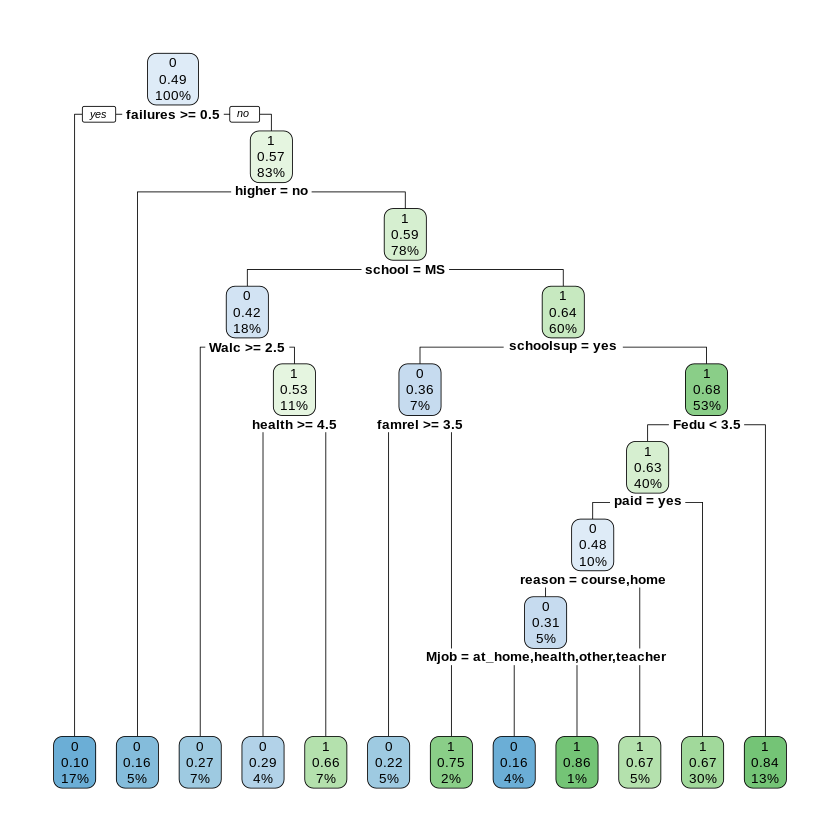

In [5]:
display_markdown("# Gini Baseline")
baseline_treeModel <- rpart(
    formula = approved ~ .,
    data = datasets$Train,
    method = "class",
    parms = list(split = "gini"))
rpart.plot(baseline_treeModel)

for (ds_name in names(datasets)) {
    ds <- datasets[[ds_name]]
    print_accuracy_table(ds_name, predict(baseline_treeModel, ds, type='class'), ds$approved)
}

In [6]:
forest_performance = data.frame(
    dataset = numeric(0),
    num_trees = numeric(0), 
    false_positives = numeric(0),
    false_negatives = numeric(0),
    true_positives = numeric(0),
    true_negatives = numeric(0)
)

for (num_trees in 1:200) {
    model <- randomForest(
        formula = approved ~ .,
        data = datasets$Train,
        ntree = num_trees)
    
    for (ds_name in names(datasets)) {
        ds <- datasets[[ds_name]]
        expected = as.logical(as.numeric(as.character(ds$approved)))
        predicted = as.logical(as.numeric(as.character(predict(model, ds))))
        
        forest_performance[nrow(forest_performance) + 1,] = list(
            dataset = ds_name,
            num_trees = num_trees,
            false_positives = sum(predicted & !expected),
            false_negatives = sum(!predicted & expected),
            true_positives = sum(predicted & expected),
            true_negatives = sum(!predicted & !expected)
        )
    }
}
forest_performance$Accuracy <- (forest_performance$true_positives + forest_performance$false_negatives) / (forest_performance$false_positives + forest_performance$false_negatives + forest_performance$true_positives + forest_performance$false_positives)
forest_performance$Normalized_Accuracy <- (forest_performance$true_positives / (forest_performance$true_positives + forest_performance$false_negatives) + forest_performance$true_negatives / (forest_performance$true_negatives + forest_performance$false_positives)) / 2
#forest_performance

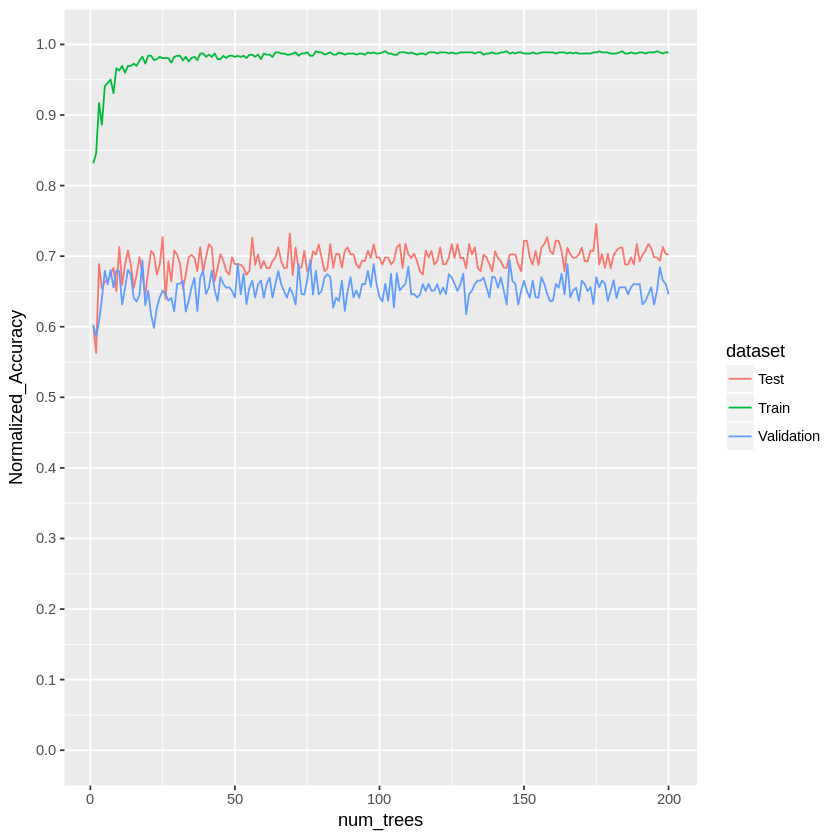

In [7]:
p <- ggplot(data=forest_performance, aes(x=num_trees, y=Normalized_Accuracy, color=dataset))
p <- p + scale_y_continuous(limits = c(0, 1), breaks=seq(0, 1, 0.1))
#p <- p + geom_smooth()
p <- p + geom_line()
#p <- p + geom_line(aes(y=Accuracy))
p
#forest_performance